# This is draft 3 of the notebook

In [66]:
# Requires GenePattern Notebook: pip install genepattern-notebook
import gp
import genepattern

# Username and password removed for security reasons.
genepattern.display(genepattern.session.register("https://cloud.genepattern.org/gp", "", ""))

GPAuthWidget()

## Loading TCGA data

In [130]:
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})

def quantile_normalize(df):
    # from https://stackoverflow.com/questions/37935920/quantile-normalization-on-pandas-dataframe/37957466
    # look into https://github.com/ShawnLYU/Quantile_Normalize
    rank_mean = df.stack().groupby(df.rank(method='first').stack().astype(int)).mean()
    return df.rank(method='min').stack().astype(int).map(rank_mean).unstack()

def filter_out_zeros(df):
    return

def remove_genes_with_all_zeros(df):
    #return df[(df.T != 0).any()]
    return df.loc[~(df==0).all(axis=1)]

# won't be used 
# def remove_genes_with_all_eps(df,eps=0.1):
#     #return df[(df.T != 0).any()]
#     return df.loc[~(df<=eps).all(axis=1)]

def log_normalize(df):
    return df.apply(np.log10)

def display_distributions(df,color='k'):
    df.apply(lambda x: sns.kdeplot(x,legend=False,color=color))
    
def make_panel(df,drop_duplicates=True,apply_log_normalize=True,color='k'):
    if drop_duplicates:
        old_len = len(df)
        df = df.loc[~df.index.duplicated(keep='first')]
        print(f'Dropped {old_len-len(df)} duplicated genes.')
    if apply_log_normalize: 
        df = log_normalize(df)
        print("Log normalization done")
#     print("This is the distribution of the log-normalized counts:")
    display_distributions(df,color)
    
    
from scipy.stats import kendalltau
def colwise_distance(df1,df2):
    # Writing readable code that works first. Optimizing later.
    
    # this assumes both dataframes have the same index and columns
    columns = list(df1)
    
    diff = pd.DataFrame()
    for col in columns:
        tau, p_value =  kendalltau(df1[col].rank().values,df2[col].rank().values)
        diff.loc['similarity',col] = tau
    # Compute the squre root of the mean of squares
    return diff

def dfdist(df1,df2):
    #Assuming the two dataframes have the same columns
    
    #drop duplicated index...
    df1 = df1.groupby(df1.index).first()
    df2 = df2.groupby(df2.index).first().dropna()
    
    #First subset the columns so only shared indexes are accouted for
    # Drop nans to keep just the common values
    df1 = df1.reindex(df2.index).dropna()
    df2 = df2.reindex(df1.index).dropna()
    
    
    distance_per_column = colwise_distance(df1,df2)
    
    #for now just adding the distance per column
    return distance_per_column.mean(axis=1)

def print_stats(df1,df2,method):
    print(f'A total of **{len(df1)-len(df2)}** genes/transcripts were dropped by {method}')
    kt = dfdist(df1,df2)
    print(f"The Kendal Tau of the genes they have in common is {kt['similarity']}")

In [131]:
import urllib.request
import urllib.parse
import os
import pandas as pd
import cuzcatlan as cusca
import numpy as np
import genepattern
import ccalnoir as ccal

def std_filter(df):
    std = df.std(axis=1)
    min_std = 0.1*std.mean() # Filter genes that are below 10th percentile
    # mean = df.mean(axis=1)
    new_std = std[std > min_std]
    print("{} genes were filtered out -- they had a Standard Deviation lower than {:2.2f} (mean std was ~{})".format(std.count() - new_std.count(), min_std, int(std.mean()) ))
    print("New gene lengths is {}".format(new_std.count()))
    filtered_df = df.iloc[new_std.index]
    return filtered_df


def sort_TCGA_samples(df, make_cls=True, name='sorted_cls.cls'):
    cols = list(df.columns)
    temp_cols = [sample[::-1] for sample in cols]
    temp_cols = sorted(temp_cols)
    if make_cls:
        cusca.list2cls(np.array([int(sample[:2][::-1][0]) for sample in temp_cols]), name_of_out=name,sep=' ')
    temp_cols = [sample[::-1] for sample in temp_cols]
    return df[temp_cols]


@genepattern.build_ui(parameters={
    "cancer_type": {
        "default": "LGG",
        "type": "choice",
        "choices": {
            "Adrenocortical Carcinoma (ACC)":"ACC",
            "Bladder Urothelial Carcinoma (BLCA)": "BLCA",
            "Breast Invasive Carcinoma (BRCA)": "BRCA",
            "Cervical Squamous Cell Carcinoma and Endocervical Adenocarcinoma (CESC)": "CESC",
            "Cholangiocarcinoma (CHOL)": "CHOL",
            "Colon Adenocarcinoma (COAD)": "COAD",
            "Lymphoid Neoplasm Diffuse Large B-cell Lymphoma (DLBC)": "DLBC",
            "Esophageal Carcinoma (ESCA)": "ESCA",
            "Glioblastoma Multiforme (GBM)":"GBM",
            "Head and Neck Squamous Cell Carcinoma (HNSC)":"HNSC",
            "Kidney Chromophobe (KICH)":"KICH",
            "Kidney Renal Clear Cell Carcinoma (KIRC)":"KIRC",
            "Kidney Renal Papillary Cell Carcinoma (KIRP)":"KIRP",
            "Acute Myeloid Leukemia (LAML)":"LAML",
            "Brain Lower Grade Glioma (LGG)":"LGG",
            "Liver Hepatocellular Carcinoma (LIHC)":"LIHC",
            "Lung Adenocarcinoma (LUAD)":"LUAD",
            "Lung Squamous Cell Carcinoma (LUSC)":"LUSC",
            "Mesothelioma (MESO)":"MESO",
            "Ovarian Serous Cystadenocarcinoma (OV)":"OV",
            "Pancreatic Adenocarcinoma (PAAD)":"PAAD",
            "Pheochromocytoma and Paraganglioma (PCPG)":"PCPG",
            "Prostate Adenocarcinoma (PRAD)":"PRAD",
            "Rectum Adenocarcinoma (READ)":"READ",
            "Sarcoma (SARC)":"SARC",
            "Skin Cutaneous Melanoma (SKCM)":"SKCM",
            "Stomach Adenocarcinoma (STAD)":"STAD",
            "Testicular Germ Cell Tumors (TGCT)":"TGCT",
            "Thyroid Carcinoma (THCA)":"THCA",
            "Thymoma (THYM)":"THYM",
            "Uterine Corpus Endometrial Carcinoma (UCEC)":"UCEC",
            "Uterine Carcinosarcoma (UCS)":"UCS",
            "Uveal Melanoma (UVM)":"UVM",
        }
    },
    "output_var":{
        "hide":True}
})
def load_TCGA_RNASeq_counts(cancer_type, load_cls=True, filter_dataset=True):
    global selected_type
    selected_type = cancer_type
    global was_filtered
    was_filtered = filter_dataset
    gct_url = f"https://datasets.genepattern.org/data/TCGA_HTSeq_counts/{cancer_type}/{cancer_type}_TCGA.gct"
    cls_url = f"https://datasets.genepattern.org/data/TCGA_HTSeq_counts/{cancer_type}/{cancer_type}_TCGA.cls"
    
    if filter_dataset:
        file_list = []
    else:
        file_list = [gct_url]
    print("Importing:",gct_url)
    urllib.request.urlretrieve(gct_url, os.path.basename(urllib.parse.urlparse(gct_url).path))
    print('\tdone importing!')
    if load_cls:
        if not(filter_dataset):
            file_list.append(cls_url)
        urllib.request.urlretrieve(cls_url, os.path.basename(urllib.parse.urlparse(cls_url).path))
    if filter_dataset:
        print('Starting the filtering process.')
        filtered_name = os.path.basename(urllib.parse.urlparse(gct_url).path).strip('.gct')+'.filtered.gct'
        filtered_df = std_filter(pd.read_table(gct_url,header=2))
        filtered_df.index = filtered_df['Name']
        filtered_df = sort_TCGA_samples(filtered_df.drop(['Name','Description'],axis=1,inplace=False), name = filtered_name.replace(".gct",".cls"))
        cusca.df2gct(filtered_df, name=filtered_name, use_index=True)
        file_list.append(filtered_name)
        file_list.append(filtered_name.replace(".gct",".cls"))
    return genepattern.GPUIOutput(files=file_list)

UIBuilder(function_import='nbtools.tool(id="load_TCGA_RNASeq_counts", origin="Notebook").function_or_method', …

In [133]:
# The code below will only run if pandas is installed: http://pandas.pydata.org
import nbtools
from gp.data import GCT
gbm_tcga_gct_dataframe = GCT(nbtools.open("https://datasets.genepattern.org/data/TCGA_HTSeq_counts/GBM/GBM_TCGA.gct"))
gbm_tcga_gct_dataframe.index = gbm_tcga_gct_dataframe.index.droplevel(1)
display(gbm_tcga_gct_dataframe.head())
len(gbm_tcga_gct_dataframe)

,TCGA-12-5299-01,TCGA-06-0156-01,TCGA-12-0618-01,TCGA-32-5222-01,TCGA-28-1747-01,TCGA-32-1970-01,TCGA-32-4213-01,TCGA-02-0047-01,TCGA-06-0646-01,TCGA-41-2572-01,...,TCGA-27-2528-01,TCGA-28-2510-01,TCGA-28-5213-01,TCGA-06-0157-01,TCGA-28-5215-01,TCGA-06-5417-01,TCGA-15-0742-01,TCGA-14-1034-01,TCGA-06-5418-01,TCGA-26-5133-01
Name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,5761,3977,4280,6968,5096,3464,1949,2425,2601,3567,...,5550,1202,3685,6977,4353,1278,4358,3935,4976,4580
TNMD,12,12,4,9,8,16,2,3,13,10,...,5,11,62,5,19,0,10,4,17,2
DPM1,1497,1501,1293,2527,1019,805,440,665,873,1173,...,1948,966,941,1153,1418,434,1590,741,1654,1418
SCYL3,673,675,728,792,563,569,127,415,699,340,...,511,528,277,559,648,333,451,222,517,548
C1orf112,416,666,565,694,342,341,123,242,480,254,...,455,200,173,491,561,123,273,223,324,341


60483

In [82]:
# gbm = remove_genes_with_all_zeros(gbm_tcga_gct_dataframe)
gbm = gbm_tcga_gct_dataframe
display(lgg.head().max(axis=1))
display(lgg.head())
display(len(lgg))

Name
TSPAN6      13993
TNMD          226
DPM1         2470
SCYL3        1660
C1orf112     1474
dtype: int64

,TCGA-S9-A6U8-01,TCGA-P5-A72W-01,TCGA-VM-A8CH-01,TCGA-DU-5849-01,TCGA-F6-A8O3-01,TCGA-P5-A735-01,TCGA-HW-7495-01,TCGA-P5-A781-01,TCGA-HT-A74O-01,TCGA-FG-A87Q-01,...,TCGA-DH-5142-01,TCGA-E1-A7YV-01,TCGA-FG-A4MX-01,TCGA-DU-8164-01,TCGA-HT-A5RA-01,TCGA-DU-6394-01,TCGA-HW-A5KL-01,TCGA-S9-A7R2-01,TCGA-VM-A8C9-01,TCGA-P5-A731-01
Name,,,,,,,,,,,,,,,,,,,,,
TSPAN6,4543,3278,1833,2745,3751,2437,3168,4018,2417,4508,...,3458,3510,1240,5572,3240,3991,3206,7277,2176,4313
TNMD,7,6,0,6,8,0,3,7,0,5,...,12,5,4,10,9,1,1,135,47,10
DPM1,1156,998,919,1098,1603,686,936,1156,963,725,...,1035,1298,658,1395,1486,1427,752,836,664,1080
SCYL3,890,404,484,736,1094,399,667,698,385,441,...,816,800,286,1190,796,1216,636,585,197,489
C1orf112,399,81,195,215,336,169,183,222,147,234,...,366,625,88,340,457,229,307,220,94,196


57652

## Plotting raw counts 

Log normalization done
This is the distribution of the log-normalized counts:


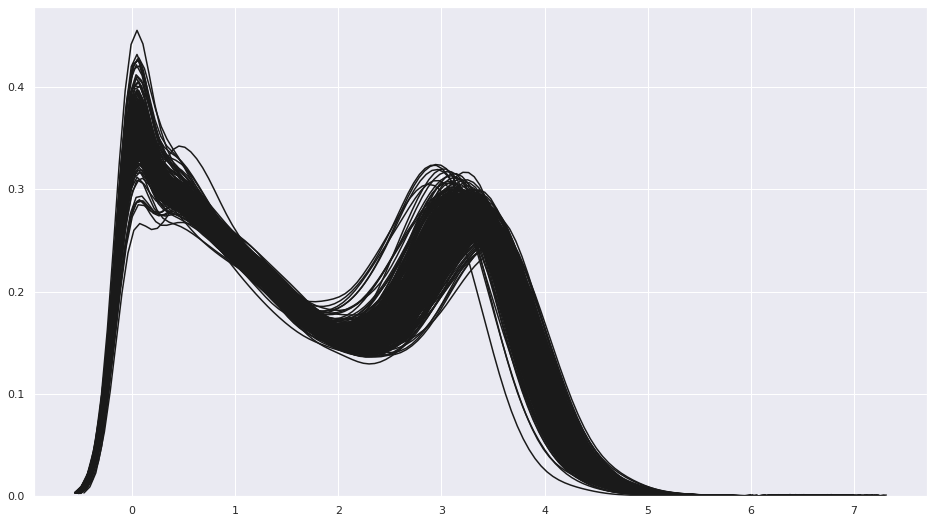

In [83]:
make_panel(lgg,apply_log_normalize=True,drop_duplicates=False)

## Using VoomNormalize 

In [67]:
voomnormalize_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00355')
voomnormalize_job_spec = voomnormalize_task.make_job_spec()
voomnormalize_job_spec.set_parameter("input.file", "https://datasets.genepattern.org/data/TCGA_HTSeq_counts/GBM/GBM_TCGA.gct")
voomnormalize_job_spec.set_parameter("cls.file", "https://datasets.genepattern.org/data/TCGA_HTSeq_counts/GBM/GBM_TCGA.cls")
voomnormalize_job_spec.set_parameter("output.file", "<input.file_basename>.VOOM.gct")
voomnormalize_job_spec.set_parameter("expression.value.filter.threshold", "1")
voomnormalize_job_spec.set_parameter("job.memory", "2 Gb")
voomnormalize_job_spec.set_parameter("job.queue", "gp-cloud-default")
voomnormalize_job_spec.set_parameter("job.cpuCount", "1")
voomnormalize_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(voomnormalize_task)

job187217 = gp.GPJob(genepattern.session.get(0), 187217)
genepattern.display(job187217)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00355')

In [116]:
# The code below will only run if pandas is installed: http://pandas.pydata.org
from gp.data import GCT
gbm_tcga_voom_gct_187217 = GCT(job187217.get_file("GBM_TCGA.VOOM.gct"))

In [142]:
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
custom_lines = [Line2D([0], [0], color='b', lw=4),
                Line2D([0], [0], color='k', lw=4),]

def print_vitals(df1,df2,method,apply_log_normalize=False):
    if isinstance(df2.index, pd.core.index.MultiIndex):
        df2.index = df2.index.droplevel(1)
#     display(df.head())
#     len(df2)
    make_panel(df1,apply_log_normalize=True,drop_duplicates=False,color='b')
    make_panel(df2,apply_log_normalize=apply_log_normalize,drop_duplicates=False,color='k')
    plt.gca().legend(custom_lines, ['Original distribution', method])
    print_stats(df1,df2,method)

Log normalization done
A total of **39245** genes/transcripts were dropped by VOOM
The Kendal Tau of the genes they have in common is 0.9999430535974148


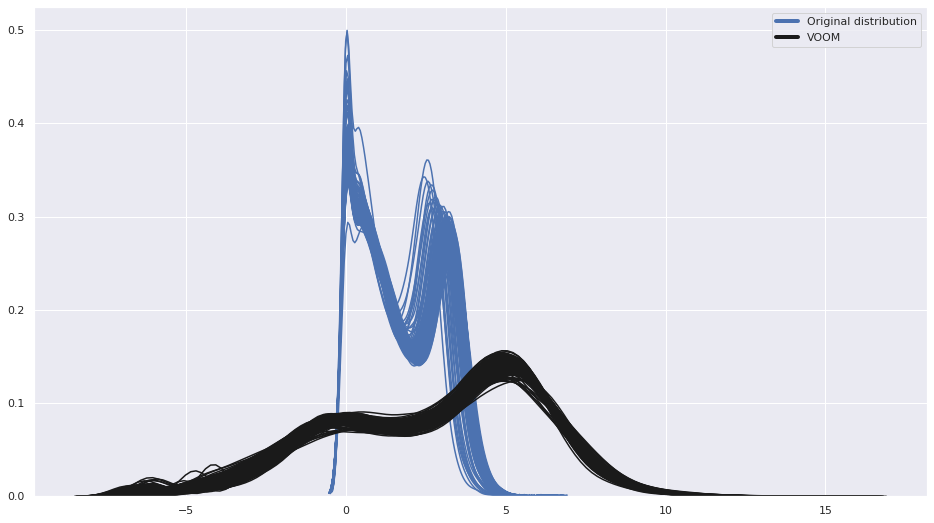

In [135]:
print_vitals(df1=gbm,df2=gbm_tcga_voom_gct_187217,method='VOOM',apply_log_normalize=False)

### LGG

Log normalization done
A total of **47031** genes/transcripts were dropped by VOOM
The Kendal Tau of the genes they have in common is 1.0


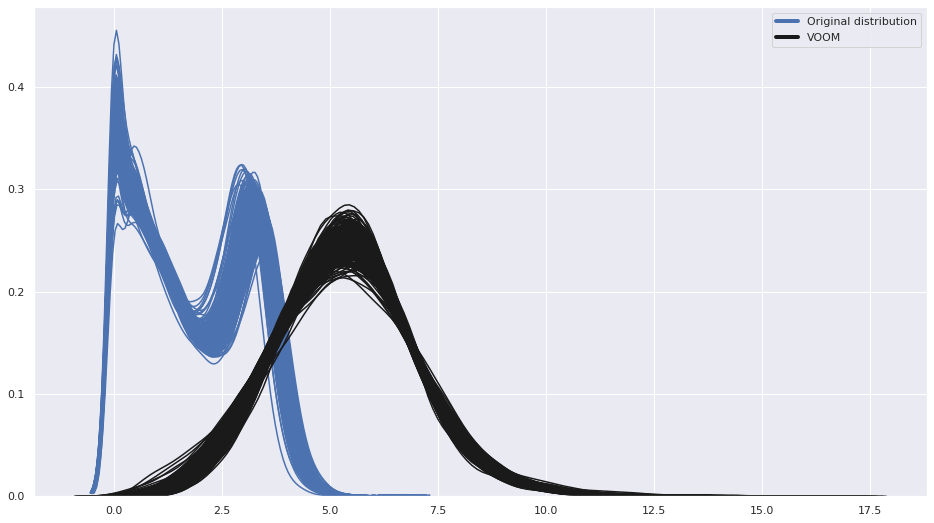

In [127]:
print_vitals(df1=lgg,df2=lgg_tcga_preprocessed_gct_187211,method='VOOM',apply_log_normalize=False)

### back to GBM

## Using DESeq2

In [69]:
deseq2_task = gp.GPTask(genepattern.session.get(0), 'urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00362')
deseq2_job_spec = deseq2_task.make_job_spec()
deseq2_job_spec.set_parameter("input.file", "https://datasets.genepattern.org/data/TCGA_HTSeq_counts/GBM/GBM_TCGA.gct")
deseq2_job_spec.set_parameter("cls.file", "https://datasets.genepattern.org/data/TCGA_HTSeq_counts/GBM/GBM_TCGA.cls")
deseq2_job_spec.set_parameter("confounding.variable.cls.file", "")
deseq2_job_spec.set_parameter("output.file.base", "<input.file_basename>_DESeq2")
deseq2_job_spec.set_parameter("qc.plot.format", "skip")
deseq2_job_spec.set_parameter("fdr.threshold", "0.1")
deseq2_job_spec.set_parameter("top.N.count", "20")
deseq2_job_spec.set_parameter("random.seed", "779948241")
deseq2_job_spec.set_parameter("job.memory", "2 Gb")
deseq2_job_spec.set_parameter("job.queue", "gp-cloud-default")
deseq2_job_spec.set_parameter("job.cpuCount", "1")
deseq2_job_spec.set_parameter("job.walltime", "02:00:00")
genepattern.display(deseq2_task)

job187218 = gp.GPJob(genepattern.session.get(0), 187218)
genepattern.display(job187218)

GPTaskWidget(lsid='urn:lsid:broad.mit.edu:cancer.software.genepattern.module.analysis:00362')

In [140]:
# The code below will only run if pandas is installed: http://pandas.pydata.org
from gp.data import GCT
gbm_tcga_deseq2_11_vs_01_normalized_counts_gct_187218 = GCT(job187218.get_file("GBM_TCGA_DESeq2.11.vs.01.normalized_counts.gct"))

Log normalization done
Log normalization done
A total of **6213** genes/transcripts were dropped by DESeq2
The Kendal Tau of the genes they have in common is 0.9999301179747584


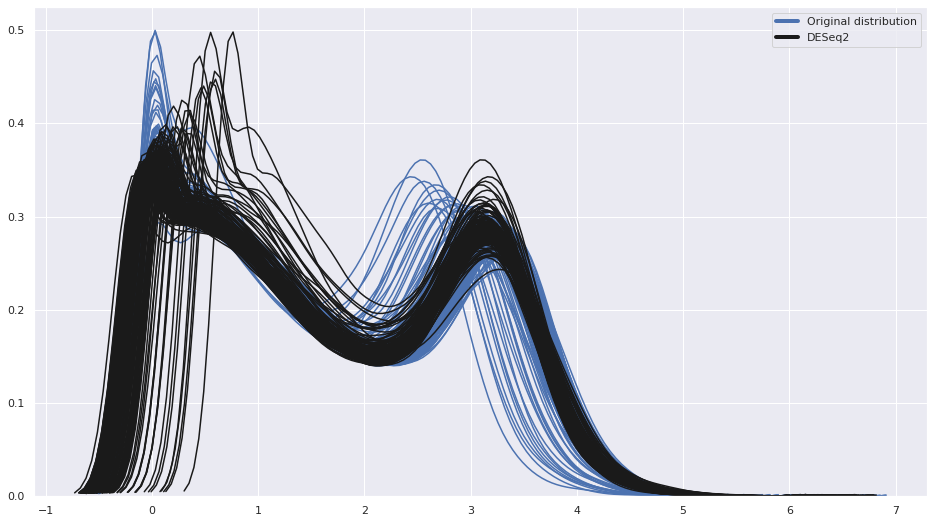

In [143]:
print_vitals(df1=gbm,df2=gbm_tcga_deseq2_11_vs_01_normalized_counts_gct_187218,method='DESeq2',apply_log_normalize=True)